# Randomized Testing

## Overview
Random testing is a black-box software testing technique where programs are tested by generating random, independent inputs. Results of the output are compared against software specifications to verify that the test output is pass or fail. **In case of absence of specifications the exceptions of the language are used** which means if an exception arises during test execution then it means there is a fault in the program, **it is also used as way to avoid biased testing** [[1]](https://en.wikipedia.org/wiki/Random_testing).


## Origin and Motivations
This test is based on the **Ininite Monkey Theorem**: "The infinite monkey theorem states that a monkey hitting keys at random on a typewriter keyboard for an infinite amount of time will almost surely type any given text, such as the complete works of William Shakespeare." [[2]](https://en.wikipedia.org/wiki/Infinite_monkey_theorem).

Adapting the theorem to our reality: an infinite random input generator can cover all the possible entries of a program. 

The idea behind the randomized testing is to test our program with a large number of inputs, randomly and fairly distributed, and compare it with the prrogram valid statements. If we have an error, we should log and try to understand it after. Normally the randomized testing take a while to finish because we need to ensure a good test coverage.

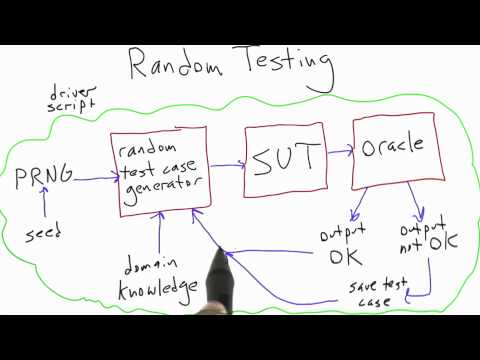

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('cwhC19Fa_84')

## Types of Randomized Testing
The types of random testing relies on the way the input data is randomized and if the test is guided or not:
- Input: The developer can either generate random data (i.e. randomize integers), randomize a sequence of data inputs (sometimes called stochastic testing, i.e. random sequence of method calls), and select random data from a database.
- Guided vs Unguided: The developer can guide or not the test flow depending on the previous data randomized(i.e. adaptative random testing[3] or feedback-directed random test generation[4]).


## Hands On 

<a href="https://colab.research.google.com/drive/1MxPaezXtSAzIjZR2z0RIRawM6SX2Uo7D?usp=sharing"> 
    <img align="left" alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg">
</a>
<br/>
<br/>
This session will show a basic function example with random test coverage. For the hands on session we'll define a basic framework to run the randomized testing:

In [263]:
from collections import namedtuple
Error = namedtuple('Error', ["input", "got", "expected"])

class RandomizedTestingFramework:    
    def run_test(self, test_function, expected_function, generator, iteration = 100):
        error = set()
        
        while (iteration := iteration - 1):
            random_input = generator()
            if not hasattr(random_input, '__iter__'):
                random_input = [random_input]
            test_input = test_function(*random_input)
            expected_input = expected_function(*random_input)
            
            if test_input != expected_input:
                error.add(Error(tuple(random_input), test_input, expected_input))

        return error
            
random_framework = RandomizedTestingFramework()

### abs()
The abs function returns the absolute value of an integer: |x| = x if x >= 0 else -x. To test this, we know that the abs(x), where x is an integer, is always greater than or equal to zero:

In [264]:
def myAbs(x: int) -> int:
    if x >= 0:
        return x
    else:
        return -x # Possible bug cause

Our random generator is simply a function that returns an integer in the range (-inf, inf). For this test, lets keep our bounds between -10 and 10.

In [265]:
from random import randint
def integerGenerator(lower_bound: int = -10, upper_bound: int = 10) -> int:
    return randint(lower_bound, upper_bound)

To test it, we must ensure that the number of iterations can cover our function. For every wrong evaluation, we will log it:

In [266]:
random_framework.run_test(myAbs, abs, integerGenerator)

set()

For our simple test, there is no error. But if we change our abs to add an error

In [267]:
def myAbs_error(x: int) -> int:
    if x >= 0:
        return x
    else:
        return 0
    
random_framework.run_test(myAbs_error, abs, integerGenerator)

{Error(input=(-10,), got=0, expected=10),
 Error(input=(-9,), got=0, expected=9),
 Error(input=(-8,), got=0, expected=8),
 Error(input=(-7,), got=0, expected=7),
 Error(input=(-6,), got=0, expected=6),
 Error(input=(-5,), got=0, expected=5),
 Error(input=(-4,), got=0, expected=4),
 Error(input=(-3,), got=0, expected=3),
 Error(input=(-2,), got=0, expected=2),
 Error(input=(-1,), got=0, expected=1)}

## multiply()
A more complex case: we want to define a multiply function that only uses binary operators. For this we can use bit operators (&, |, >>, <<), comparators (==, >, <, ...) and the `abs` function.

In [272]:
def multiply(a: int, b: int) -> int:
    def add(a: int, b:int) -> int:
        while b:
            a, b = (a ^ b), (a & b) << 1
        return a

    result = 0
    negative = a < 0 or b < 0
    a, b = abs(a), abs(b)
    
    while b:
        if b & 1: result = add(result, a)

        a = add(a, a)
        b >>= 1

    return -result if negative else result

In [273]:
def tuple_generator(size = 2):
    return lambda: [integerGenerator() for _ in range(size)]

random_framework.run_test(multiply, lambda a,b: a*b, tuple_generator())

{Error(input=(-10, -7), got=-70, expected=70),
 Error(input=(-9, -5), got=-45, expected=45),
 Error(input=(-9, -4), got=-36, expected=36),
 Error(input=(-9, -3), got=-27, expected=27),
 Error(input=(-8, -6), got=-48, expected=48),
 Error(input=(-7, -8), got=-56, expected=56),
 Error(input=(-7, -6), got=-42, expected=42),
 Error(input=(-7, -1), got=-7, expected=7),
 Error(input=(-6, -4), got=-24, expected=24),
 Error(input=(-5, -8), got=-40, expected=40),
 Error(input=(-5, -7), got=-35, expected=35),
 Error(input=(-5, -1), got=-5, expected=5),
 Error(input=(-4, -6), got=-24, expected=24),
 Error(input=(-4, -2), got=-8, expected=8),
 Error(input=(-3, -8), got=-24, expected=24),
 Error(input=(-3, -7), got=-21, expected=21),
 Error(input=(-3, -2), got=-6, expected=6),
 Error(input=(-1, -8), got=-8, expected=8)}

Here we can se an error when both values are negative and we have many cases where this bug occur. So let's fix it

In [280]:
def multiply(a: int, b: int) -> int:
    def add(a: int, b:int) -> int:
        while b:
            a, b = (a ^ b), (a & b) << 1
        return a

    result = 0
    negative = (a < 0) ^ (b < 0)
    a, b = abs(a), abs(b)
    
    while b:
        if b & 1: result = add(result, a)

        a = add(a, a)
        b >>= 1

    return -result if negative else result

random_framework.run_test(multiply, lambda a,b: a*b, tuple_generator())

set()

## Considerations
Randomized testings are really useful for some reasons like: is simple to implement and the developer can perform a random test session really quickly and doesn't have any bias since all the test cases are randomly generated. On the other hand, this kind of test only finds basic bugs and doesn't perform well compared with other more robust test methods. It's a good additional method to use in a system.

## References

1. https://en.wikipedia.org/wiki/Random_testing
2. https://en.wikipedia.org/wiki/Infinite_monkey_theorem
3.  Pacheco, Carlos; Shuvendu K. Lahiri; Michael D. Ernst; Thomas Ball (May 2007). "Feedback-directed random test generation". ICSE '07: Proceedings of the 29th International Conference on Software Engineering: 75–84. ISSN 0270-5257.
4.  Chen, T.Y.; H. Leung; I.K. Mak (2005). "Adaptive Random Testing". Advances in Computer Science - ASIAN 2004. Higher-Level Decision Making: 320–329.
